# Objective: To peform exploratory data analysis on amazon fine food reviews dataset, and perform natural language processing techniques like bag of words, uni gram, bi gram word 2 vec, average word 2 vec and tfidf word2vec, and plot tsne's on the reviews

## data source: https://www.kaggle.com/snap/amazon-fine-food-reviews

1. Number of reviews: 568,454
2. Number of users: 256,059
3. Number of products: 74,258
4. Timespan: Oct 1999 - Oct 2012
5. Number of Attributes/Columns in data: 10 
6. Attribute Information:
    1. Id
    2. ProductId - unique identifier for the product
    3. UserId - unqiue identifier for the user
    4. ProfileName
    5. HelpfulnessNumerator - number of users who found the review helpful
    6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7. Score - rating between 1 and 5
    8. Time - timestamp for the review
    9. Summary - brief summary of the review
    10. Text - text of the review

In [1]:
import pandas as pd 
import numpy as np
import sqlite3
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
import string
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import time
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# establishing a connection with amazon databasae
amazon_db_con = sqlite3.connect('database.sqlite')

In [4]:
filtered_data = pd.read_sql("SELECT * FROM Reviews WHERE Score != 3", amazon_db_con)

In [5]:
filtered_data.shape

(525814, 10)

In [6]:
# n.o of reviews after deleting the rating 3 reviews
(filtered_data['Score'] != 3).sum()

525814

In [7]:
# lets say all the reviews less than 3 as negative, and greater than 3 as positive
filtered_data['Score'] = filtered_data.Score.apply(lambda x: 'Positive' if x > 3 else 'Negative')

In [8]:
filtered_data.Score.unique()

array(['Positive', 'Negative'], dtype=object)

# Data Wrangling

In [9]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
# sorting the data by productid
sorted_data = filtered_data.sort_values('ProductId')

In [11]:
# droping the duplicate rows and storing the sorted data in final_df
final_df = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})

In [12]:
#lets see if there are any rows where helpfulnessnumerator is greater than helpfuness denominator
num_great = sorted_data.query('HelpfulnessNumerator > HelpfulnessDenominator')
num_great

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,Positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,Positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
num_great.index

Int64Index([59301, 41159], dtype='int64')

In [14]:
#removing the the 2 reviews where helpfulnessnumerator is greater than denominator
final_df = final_df.drop(num_great.index)

In [15]:
# lets check whether the two rows are deleted
final_df.query('HelpfulnessNumerator > HelpfulnessDenominator')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [16]:
final_df.shape

(364171, 10)

# Exploratory Data Analysis

In [17]:
# seeing the first review which contains html tags
for sent in final_df['Text'].values:
    if len(re.findall('<.*?>', sent)):
        print(sent)
        break

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [18]:
stopw = set(stopwords.words('english'))
snow = nltk.stem.SnowballStemmer('english')

In [19]:
# lets remove words like not, very from stop words as they are meaninging in the reviews 
reqd_words = set(['only','very',"doesn't",'few','not'])
stopw = stopw - reqd_words

In [20]:
def clean_html(review):
    '''This function cleans html tags if any
    , in the review'''
    cleaner = re.compile('<.*?>')
    clean_txt  = re.sub(cleaner, ' ', review)
    return clean_txt

def cleanpunc(sentence): 
    '''function to clean the word of any punctuation
    or special characters'''
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stopw)
print('****************************')
print(snow.stem('beautiful'))

{'because', 'most', 're', "she's", "you're", 'again', 'll', "couldn't", 'having', 'all', 'aren', 'themselves', 'been', "wasn't", 'of', 'until', 'him', 'herself', 'don', 'on', 'will', 'nor', 'his', 'have', 'did', 'yourself', 'yours', 'that', "aren't", "mightn't", 'while', "won't", 'so', 'be', 'when', 'your', 'can', 'ain', 'mightn', 'such', 'you', 'theirs', 'other', 'itself', 'they', 'its', 'or', 'each', 'no', 'as', 'these', "don't", 'any', 'once', 'haven', 'some', 'those', 'hers', 'was', 'i', 'more', 'she', 'who', 'hasn', "you'll", 'both', 'under', 'now', 'off', 'yourselves', 'to', 'ma', "should've", 'where', 'm', 'himself', 'into', 'needn', "you'd", 'between', 'above', 'over', 've', 'out', 'what', 'them', "weren't", 'doesn', 'but', 'were', "you've", "it's", 'below', 'is', 'hadn', 'ourselves', 'being', "isn't", 'has', 'how', 'with', 'their', 'we', 'and', 'why', 's', "hasn't", 'against', 'her', 'it', "shan't", 'y', 'the', 'same', 'through', 'couldn', 'whom', 'this', 'own', "haven't", 'ar

To analyze the reviews and convert to vectors lets perform the following steps

1. iterating through each of the review(# 1st loop)
2. cleaning any html content of the review 
3. splitting individually all the words of the review into a list 
4. apply cleanpunc function on each word of the list so that we can remove if any punctiations are there
5. checking whether the cleaned word is there in the stop words
6. add the word to the new list if the cleaned word is not the stop words, and it is alphabetic and length is greater than 2
7. Separately store all the positve words and negative words in two separate lists
8. now make whole new list into a string
9. the new string is the processed review

In [21]:
final_cleaned_reviews = []
all_positive_words = []
all_negative_words = []
start_time = time.time()
for i,review in enumerate(final_df['Text'].values):
    review_filtered_words = []
    html_free = clean_html(review)
    for h_free_word in html_free.split():
        for clean_word in cleanpunc(h_free_word).split():
            if (((clean_word.isalpha()) & (len(clean_word)>2)) & \
                ((clean_word.lower() not in stopw))):
                final_word = snow.stem(clean_word.lower())
                review_filtered_words.append(final_word)
                if final_df['Score'].values[i] == 'Positive':
                    all_positive_words.append(final_word)
                else:
                    all_negative_words.append(final_word)
    final_str = " ".join(review_filtered_words)
    final_cleaned_reviews.append(final_str)
end_time = time.time()
print('time took is ', (end_time-start_time))

time took is  459.0795726776123


In [22]:
%%time
# adding the cleaned reviews to dataframe
final_df['CleanedText']=final_cleaned_reviews

Wall time: 21.5 ms


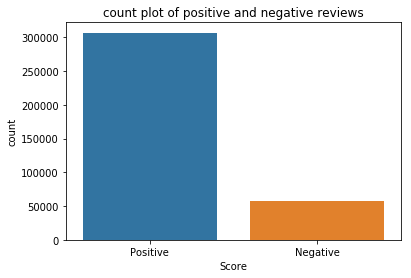

In [96]:
# lets see the 
sns.countplot(final_df.Score);
plt.title('count plot of positive and negative reviews');

In [23]:
final_df['Score'].value_counts(normalize=True)

Positive    0.843178
Negative    0.156822
Name: Score, dtype: float64

In [24]:
final_df['Score'][:50000].value_counts(normalize=True)

Positive    0.8508
Negative    0.1492
Name: Score, dtype: float64

1. As you can see in the final dataset positive reviews are 84.3% and negative reviews are 15.6%
2. From above, the first 50000 datapoints also has almost same distribution of positve and negative reviews like the whole dataset
### Since the tsne takes too much time for plotting on the whole dataset, I wil calculate all the tsne plots and nlp techniqes in the first 50000 datapoints as they have similar distribution like whole dataset

## Bag of Words

In [25]:
%%time
# lets perform the bag of words on the cleaned text
count_vect = CountVectorizer()
final_unigram = count_vect.fit_transform(final_df['CleanedText'][:50000])

Wall time: 2.41 s


In [26]:
type(final_unigram)

scipy.sparse.csr.csr_matrix

In [27]:
final_unigram.shape, final_df.shape

((50000, 28175), (364171, 11))

### since the final unigram is a sparce matrix and PCA won't work on sparse martrices, we are  using TruncatedSVD


In [28]:
def tsne_generator(matrix, perplex_list, svd, components):
    '''function generates tsne dimensions dataframes of datapoints 
    which can be used to plot TSNE's
    matrix: on which the operatoins has to be performed
    perplex_list: perplexity values in a list
    svd: Please enter True or False
        True means it performs TruncatedSVD
        else it skips and directly computes TSNE
    Components: number of components you want in the output for tsvd
    for tsne it doesnt mean anything, just give any value'''
    
    tsne_dict = {}
    if svd:
        svd = TruncatedSVD(n_components=components, random_state=42)
        method_svd = svd.fit_transform(matrix)
        print('variance explained by svd on {} components is '.format(components)\
              , (svd.explained_variance_ratio_).sum())
        
        for x in range(len(perplex_list)):
            start_time = time.time()
            tsne = TSNE(n_components=2,perplexity=perplex_list[x],random_state=42)
            final_tsne = tsne.fit_transform(method_svd[:50000]) # dont forget 50000
        #change from 300 to 100000
        #print('shape of final_tsne', final_tsne.shape)
            tsne_df = pd.DataFrame(final_tsne, columns=['Dimension1','Dimension2'])
            tsne_df['Score'] = final_df['Score'].iloc[:tsne_df.shape[0]].values
            tsne_dict['perplex_{}_df'.format(perplex_list[x])] = tsne_df
            end_time = time.time()
            print('time took for {} perplexity tsne is'.format(perplex_list[x])\
                  ,  (end_time-start_time))
    else:
        for x in range(len(perplex_list)):
            start_time = time.time()
            tsne = TSNE(n_components=2,perplexity=perplex_list[x],random_state=42)
            final_tsne = tsne.fit_transform(matrix) #dont forget 50000
        #change from 300 to 100000
        #print('shape of final_tsne', final_tsne.shape)
            tsne_df = pd.DataFrame(final_tsne, columns=['Dimension1','Dimension2'])
            tsne_df['Score'] = final_df['Score'].iloc[:tsne_df.shape[0]].values
            tsne_dict['perplex_{}_df'.format(perplex_list[x])] = tsne_df
            end_time = time.time()
            print('time took for {} perplexity tsne is'.format(perplex_list[x])\
                  ,  (end_time-start_time))
    return tsne_dict

In [30]:
%%time
sam_dict = tsne_generator(final_unigram, [30,50], True, 1800)  # change to 1800 dont forget

variance explained by svd on 1800 components is  0.918004752429
time took for 30 perplexity tsne is 11177.328001260757
time took for 50 perplexity tsne is 11824.343887329102
Wall time: 6h 25min 40s


In [31]:
list(sam_dict.keys())

['perplex_30_df', 'perplex_50_df']

In [32]:
sam_dict['perplex_30_df'].to_csv('unigram_30_perplexity.csv', index=False)
sam_dict['perplex_50_df'].to_csv('unigram_50_perplexity.csv', index=False)

### Used the above two lines of code to generate tsne dataframes and stored in the csv files
using the stores csv files to plot tsne

In [29]:
unigram_30_perplexity = pd.read_csv('unigram_30_perplexity.csv')

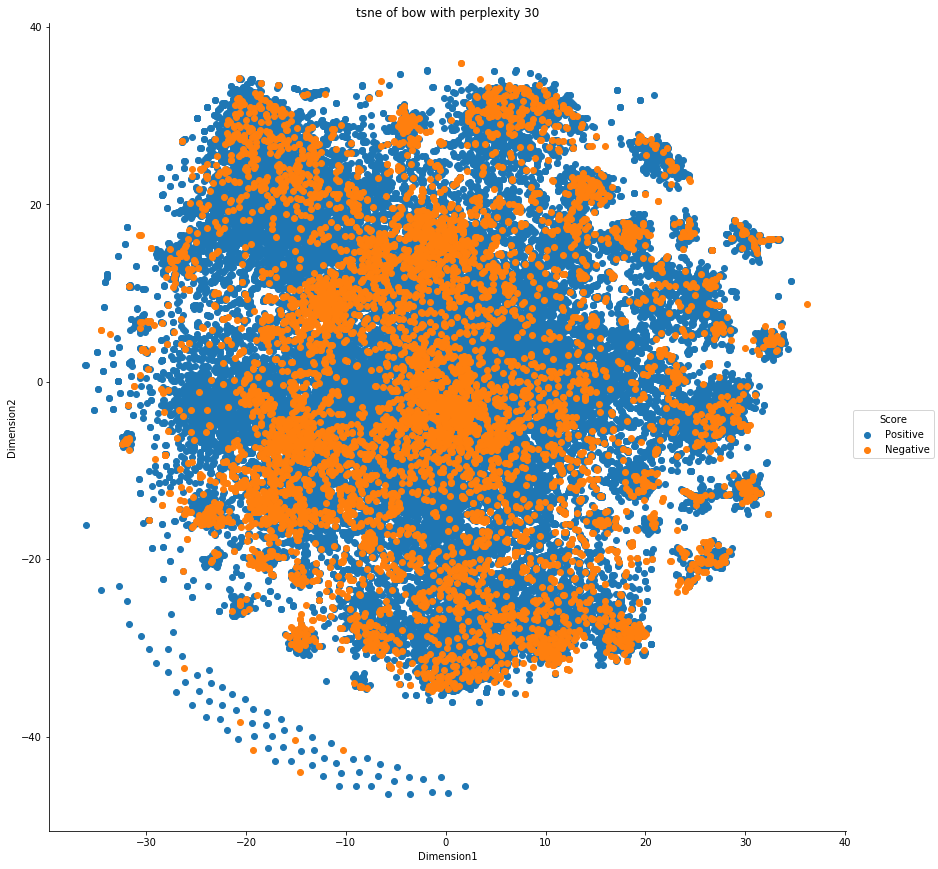

In [30]:
sns.FacetGrid(unigram_30_perplexity, hue='Score', size=12).map\
(plt.scatter, 'Dimension1','Dimension2').add_legend();
plt.title('tsne of bow with perplexity 30');

### observation : the positive and negative reviews of bag of words with 30 perplexity are pretty much overlapped on each other

In [31]:
unigram_50_perplexity = pd.read_csv('unigram_50_perplexity.csv')

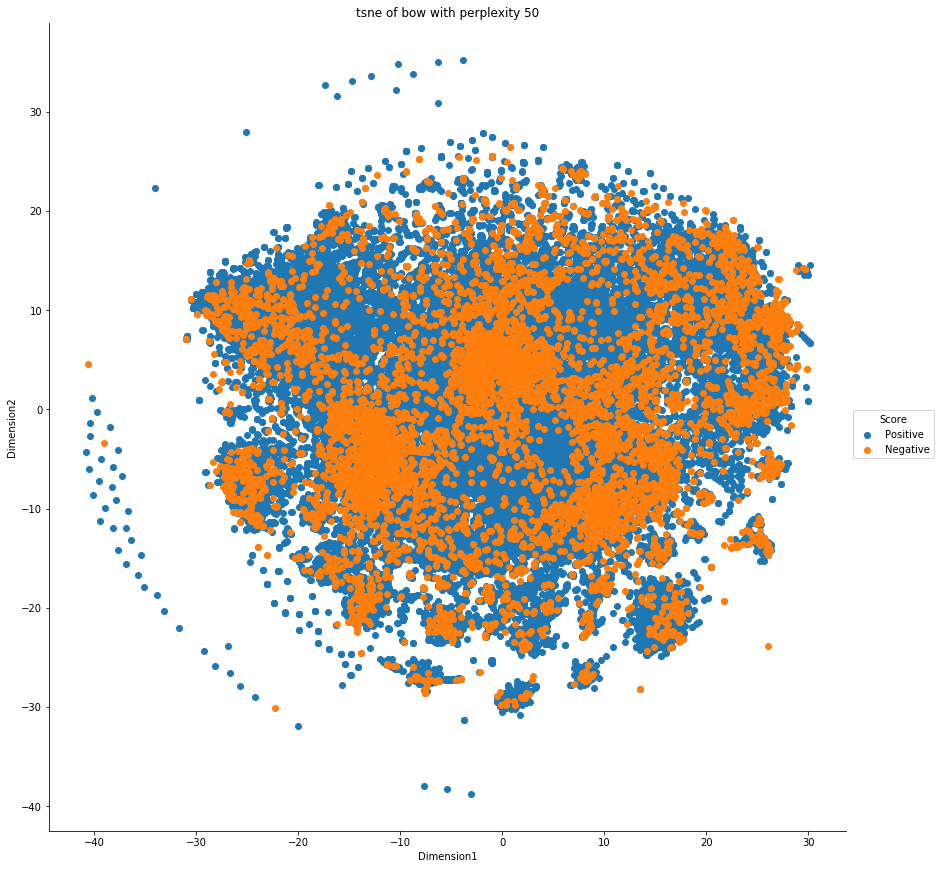

In [32]:
sns.FacetGrid(unigram_50_perplexity, hue='Score', size=12).map\
(plt.scatter, 'Dimension1','Dimension2').add_legend();
plt.title('tsne of bow with perplexity 50');

### observation : the tsne with 50 perplexity is almost similar like the 30 perplexity plot and there is no big difference so the previous observation still holds

### Bi grams and N grams

In [33]:
%%time
positive_freq_dist = nltk.FreqDist(all_positive_words)
negative_freq_dist = nltk.FreqDist(all_negative_words)

Wall time: 13 s


In [34]:
print(positive_freq_dist.most_common(20))
print('')
print(negative_freq_dist.most_common(20))

[('not', 146797), ('like', 139429), ('tast', 129047), ('good', 112766), ('flavor', 109624), ('love', 107357), ('use', 103888), ('great', 103870), ('one', 96726), ('product', 91033), ('veri', 90838), ('tri', 86791), ('tea', 83888), ('coffe', 78814), ('make', 75107), ('get', 72125), ('food', 64802), ('would', 55568), ('time', 55264), ('buy', 54198)]

[('not', 54378), ('tast', 34585), ('like', 32330), ('product', 28218), ('one', 20569), ('flavor', 19575), ('would', 17972), ('tri', 17753), ('veri', 17011), ('use', 15302), ('good', 15041), ('coffe', 14716), ('get', 13786), ('buy', 13752), ('order', 12871), ('food', 12754), ('dont', 11877), ('tea', 11665), ('even', 11085), ('box', 10844)]


1. we can see that 'like' is the 2nd most common positive frequency distribution word
2. Also the same 'like' is also the 3rd most common negative frequency distribution word
3. This is happening because the uni gram doesn't take the neighboring words into the account, thats why it can't distinguish between the like and not like(not is removed by the stop word, Even if we didn't remove the not also uni grams treat not like as two sepaate words and they can understand the meaning of not liking
4. This problem can be eliminated by doing the bi grams and n grams 

In [35]:
%%time
# lets apply the bigram technique on the cleaned Text column of final_df
bigram_vect = CountVectorizer(ngram_range=(1,2))
bigram_sparse = bigram_vect.fit_transform(final_df['CleanedText'][:50000].values)

Wall time: 7.93 s


In [36]:
bigram_sparse.shape

(50000, 781058)

In [39]:
%%time
bigram_dict = tsne_generator(bigram_sparse, [30,50], True, 2000) # change 30 to 30,50 2000 dont forget

variance explained by svd on 2000 components is  0.641869099973
time took for 30 perplexity tsne is 12062.683533906937
time took for 50 perplexity tsne is 12967.766365528107
Wall time: 7h 31min 50s


In [40]:
list(bigram_dict.keys())

['perplex_30_df', 'perplex_50_df']

In [41]:
bigram_dict['perplex_30_df'].to_csv('bigram_30_perplexity.csv', index=False)
bigram_dict['perplex_50_df'].to_csv('bigram_50_perplexity.csv', index=False)

In [37]:
bigram_30_perplexity = pd.read_csv('bigram_30_perplexity.csv')
bigram_50_perplexity = pd.read_csv('bigram_50_perplexity.csv')

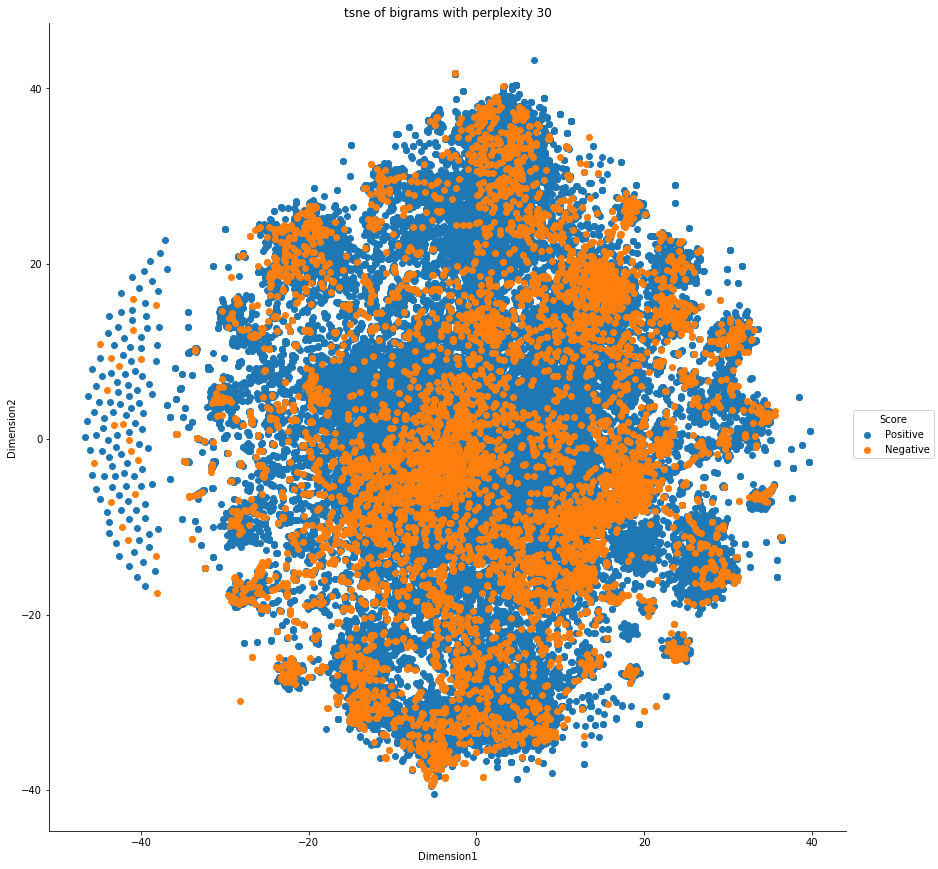

In [38]:
sns.FacetGrid(bigram_30_perplexity, hue='Score', size=12).map\
(plt.scatter,'Dimension1','Dimension2').add_legend();
plt.title('tsne of bigrams with perplexity 30');

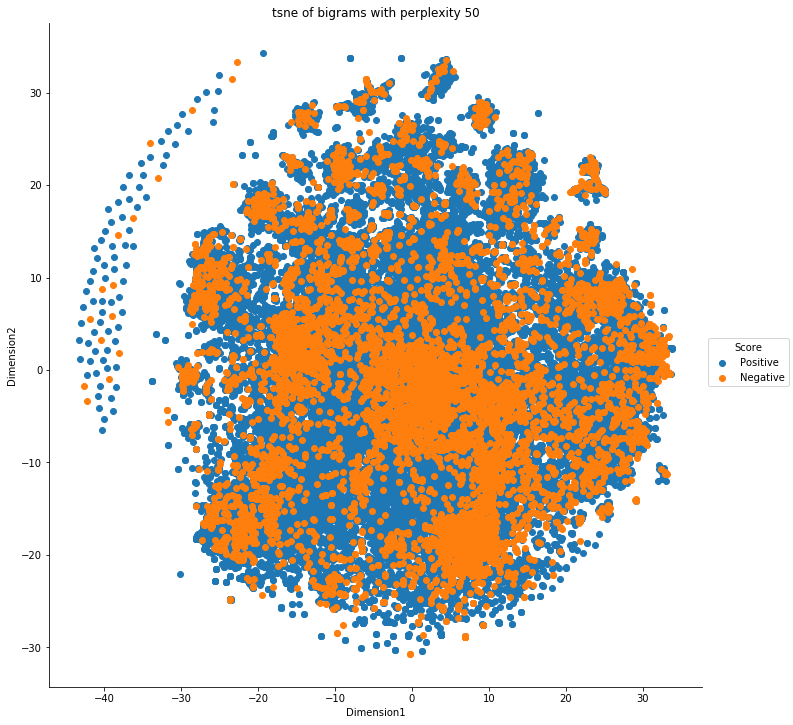

In [39]:
sns.FacetGrid(bigram_50_perplexity, hue='Score', size=10).map\
(plt.scatter,'Dimension1','Dimension2').add_legend();
plt.title('tsne of bigrams with perplexity 50');

### observation : the positive and negative reviews of bigrams with 30 and 50 perplexity are pretty much overlapped on each other

## TF-IDF

In [40]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(final_df['CleanedText'][:50000].values)

In [41]:
tfidf_matrix.shape

(50000, 781058)

In [42]:
bigram_vect.get_feature_names() == tfidf.get_feature_names()

True

In [43]:
features = tfidf.get_feature_names()
len(features)

781058

In [97]:
'''%%time
tfidf_dict = tsne_generator(tfidf_matrix, [30,50], True, 1500) '''

'%%time\ntfidf_dict = tsne_generator(tfidf_matrix, [30,50], True, 1500) '

Used the above code to generate TSNE

In [50]:
tfidf_dict.keys()

dict_keys(['perplex_30_df', 'perplex_50_df'])

In [51]:
tfidf_dict['perplex_30_df'].to_csv('tfidf_30_perplexity.csv', index=False)
tfidf_dict['perplex_50_df'].to_csv('tfidf_50_perplexity.csv', index=False)

In [98]:
tfidf_30_perplexity = pd.read_csv('tfidf_30_perplexity.csv')
tfidf_50_perplexity = pd.read_csv('tfidf_50_perplexity.csv')

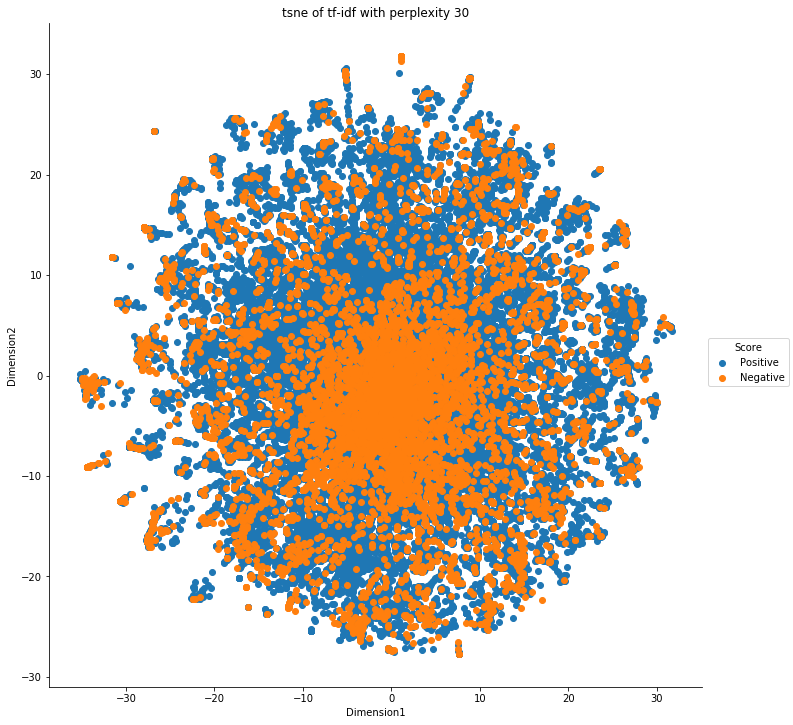

In [99]:
#tsne of tfidf with 30 perplexity

sns.FacetGrid(tfidf_30_perplexity, hue='Score', size=10).\
map(plt.scatter,'Dimension1','Dimension2').add_legend();
plt.title('tsne of tf-idf with perplexity 30');

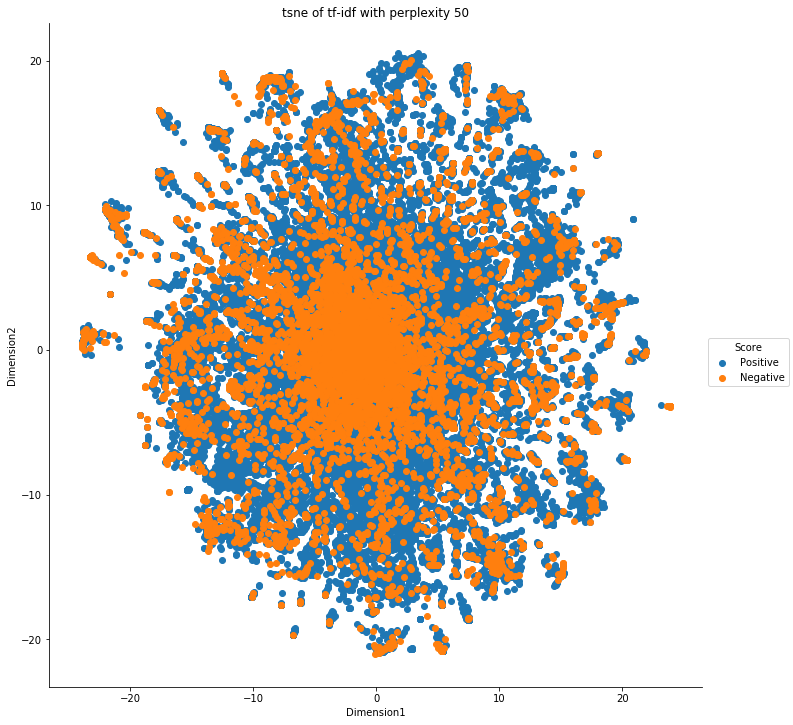

In [100]:
#tsne of tfidf with 50 perplexity

sns.FacetGrid(tfidf_50_perplexity, hue='Score', size=10).\
map(plt.scatter,'Dimension1','Dimension2').add_legend();
plt.title('tsne of tf-idf with perplexity 50');

### observation : the positive and negative reviews of tf-idf with 30 perplexity and 50 are pretty much overlapped on each other

In [44]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# calling top_tfidf_feats to see top 25 tfidf words of 2nd row
top_tfidf = top_tfidf_feats(tfidf_matrix[1,:].toarray()[0],features,25)

In [45]:
top_tfidf

,feature,tfidf
0,keep page,0.179925
1,version paperback,0.179925
2,cover version,0.179925
3,kind flimsi,0.179925
4,rosi movi,0.179925
5,flimsi take,0.179925
6,movi incorpor,0.179925
7,miss hard,0.179925
8,read sendak,0.179925
9,paperback seem,0.179925


## word 2 vec

In [56]:
%%time
# Training our own Word2Vec model using your reviews text corpus

#import gensim
i=0
list_of_sent=[]
for sent in final_df['CleanedText'][:50000].values:
    list_of_sent.append(sent.split(' '))

Wall time: 234 ms


In [57]:
len(list_of_sent)

50000

In [59]:
%%time
# lets apply word2vec on list_of_sent
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

Wall time: 8.48 s


In [60]:
words = list(w2v_model.wv.vocab)
print(len(words))

9622


In [61]:
type(w2v_model)

gensim.models.word2vec.Word2Vec

## average word 2 vec

In average word2vec we sum all w2v of every word in the document and devide the total sum with the total numbers of words in the documnet
This process will be repeated to every document in the corpus

In [101]:
%%time
sent_w2v = []
for sent in list_of_sent:
    sum_w2v = np.zeros(50)
    for word in sent:
        try:
            sum_w2v += w2v_model.wv[word]
        except:
            pass
    sent_w2v.append(sum_w2v/len(sent))

Wall time: 9.31 s


In [102]:
print(len(sent_w2v), len(sent_w2v[0]))

50000 50


In [103]:
sent_w2v_array = np.array(sent_w2v)
sent_w2v_array.shape

(50000, 50)

In [104]:
%%time
# lets call the tsne generator on the sent_w2v_array
sw2v_dict = tsne_generator(sent_w2v_array, [30,50], False,50)

time took for 30 perplexity tsne is 2532.931277036667
time took for 50 perplexity tsne is 3159.297741174698
Wall time: 1h 34min 52s


In [105]:
sw2v_dict.keys()

dict_keys(['perplex_30_df', 'perplex_50_df'])

In [106]:
sw2v_dict['perplex_30_df'].to_csv('sw2v_30_perplexity.csv', index=False)
sw2v_dict['perplex_50_df'].to_csv('sw2v_50_perplexity.csv', index=False)

In [107]:
sw2v_30_perplexity = pd.read_csv('sw2v_30_perplexity.csv')
sw2v_50_perplexity = pd.read_csv('sw2v_50_perplexity.csv')

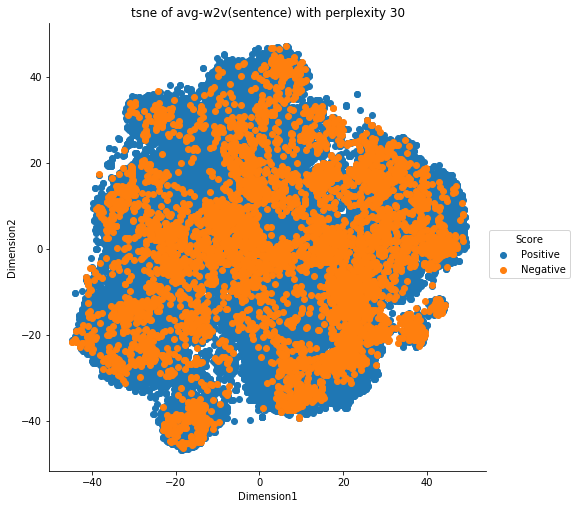

In [108]:
sns.FacetGrid(sw2v_30_perplexity, hue='Score',size=7).\
map(plt.scatter,'Dimension1','Dimension2').add_legend();
plt.title('tsne of avg-w2v(sentence) with perplexity 30');

### observation : the positive and negative reviews of avg_w2v(sent_w2v) with 30 perplexity are pretty much overlapped on each other, even though we can see small clusters , we cant clearly distinguish the positive and negative reviews

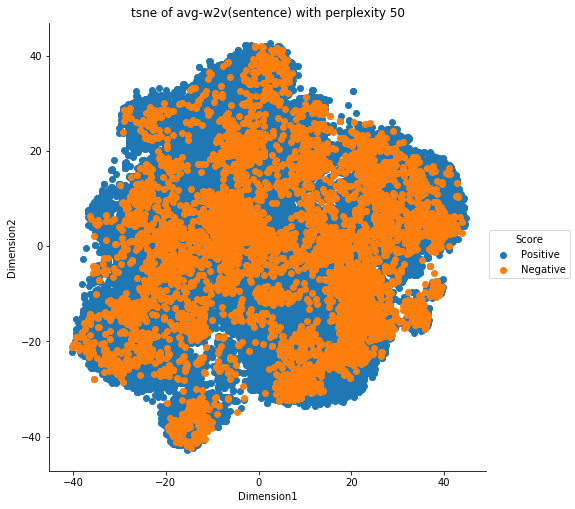

In [110]:
sns.FacetGrid(sw2v_50_perplexity, hue='Score',size=7).\
map(plt.scatter,'Dimension1','Dimension2').add_legend();
plt.title('tsne of avg-w2v(sentence) with perplexity 50');

### observation : tsne of 50 perplexity avg_w2v is almost similar with 30 perplexity so the previous observation still holds the same

## tfidf word 2 vec

In [66]:
from datetime import timedelta

In [65]:
tfidf_features_list = tfidf.get_feature_names() 

In [67]:
%%time 
sent_tfidf_w2v_list = []
t_0 = time.time()
for row, sent in enumerate(list_of_sent): #dont forget
    sum_tfidf_w2v = np.zeros(50)
    weighted_tfidf = []
    for word in sent:
        try:
            tfidf_value = tfidf_matrix[row, tfidf_features_list.index(word)]
            weighted_tfidf.append(tfidf_value)
            sum_tfidf_w2v += (tfidf_value * w2v_model.wv[word])
        except:
            pass
    sent_tfidf_w2v_list.append(sum_tfidf_w2v/sum(weighted_tfidf))
    if (row%1000)== 0:
        print('time took for {} rows is {}'.format\
              (row, str(timedelta(seconds=time.time() - t_0))))

time took for 0 rows is 0:00:00.984413
time took for 1000 rows is 0:20:17.501192
time took for 2000 rows is 0:48:36.567338
time took for 3000 rows is 1:13:52.482328
time took for 4000 rows is 1:37:52.677560
time took for 5000 rows is 2:01:44.030348
time took for 6000 rows is 2:22:28.850107
time took for 7000 rows is 2:43:51.795249
time took for 8000 rows is 3:05:17.519814
time took for 9000 rows is 3:25:23.117093
time took for 10000 rows is 3:43:22.264143
time took for 11000 rows is 4:01:34.600934
time took for 12000 rows is 4:21:24.245585
time took for 13000 rows is 4:41:36.519257
time took for 14000 rows is 5:02:57.647218
time took for 15000 rows is 5:25:54.047391
time took for 16000 rows is 5:47:20.882735
time took for 17000 rows is 6:11:53.703283
time took for 18000 rows is 6:31:54.099455
time took for 19000 rows is 6:52:29.978615
time took for 20000 rows is 7:14:14.738612
time took for 21000 rows is 7:32:01.837912
time took for 22000 rows is 7:49:26.608546
time took for 23000 rows

In [68]:
avg_tfidf_w2v_df = pd.DataFrame(sent_tfidf_w2v_list)

In [70]:
avg_tfidf_w2v_df.to_csv('sent_tfidf_w2v_list_df', index=False)

In [69]:
avg_tfidf_w2v_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.019711,0.000483,-0.068961,-0.528823,0.595068,-0.018169,0.422305,0.211096,-0.030700,0.284475,...,0.143985,-0.251233,0.279600,0.422947,0.164623,-0.111301,-0.295375,-0.002811,-0.205131,-0.459726
1,-0.060859,-0.121658,-0.194352,0.185092,0.355258,-0.122669,0.082520,0.037880,-0.251171,0.149135,...,-0.187497,-0.150176,-0.397863,0.293843,0.211409,-0.103404,-0.028497,-0.061354,-0.012870,-0.266044
2,-0.026947,-0.141671,-0.277593,-0.070501,0.720678,-0.165748,0.743936,0.042176,0.011677,0.458639,...,0.352243,0.109892,0.648308,0.263989,0.366127,-0.217076,-0.090290,0.093748,-0.023352,-0.495762
3,-0.555761,-0.377869,-0.063710,0.057195,0.101046,-0.265849,0.121646,0.250497,-0.229972,0.144256,...,0.166999,0.267472,-0.393564,0.180144,0.166684,0.184170,0.165577,-0.270136,0.063609,-0.138648
4,-0.042395,0.009125,-0.301905,-0.616197,0.742730,-0.045101,0.793578,0.234405,0.004764,0.278413,...,0.664889,0.366085,0.630337,0.520086,0.437972,-0.206217,0.169679,-0.174914,-0.088449,-0.731540


In [72]:
tfidf_w2v_matrix = np.array(sent_tfidf_w2v_list)

In [84]:
tfidf_w2v_dict = tsne_generator(tfidf_w2v_matrix, [30,50], False, 50)

time took for 30 perplexity tsne is 2522.7310168743134
time took for 50 perplexity tsne is 2965.873532295227


In [85]:
tfidf_w2v_dict['perplex_30_df'].to_csv('tfidf_w2v_30perplex.csv', index=False)
tfidf_w2v_dict['perplex_50_df'].to_csv('tfidf_w2v_50perplex.csv', index=False)

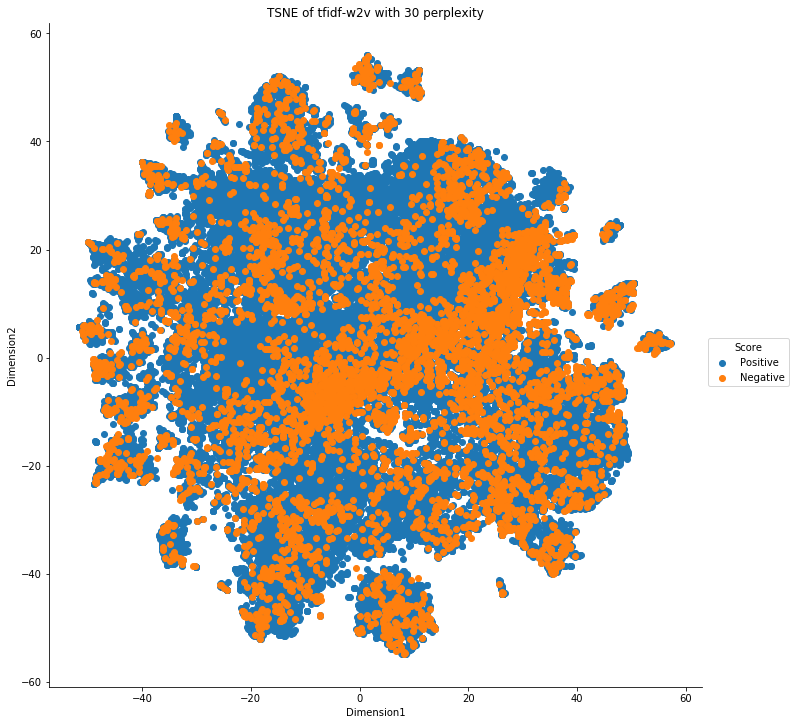

In [89]:
sns.FacetGrid(tfidf_w2v_dict['perplex_30_df'], hue='Score', size=10).\
map(plt.scatter, 'Dimension1','Dimension2').add_legend();
plt.title('TSNE of tfidf-w2v with 30 perplexity');

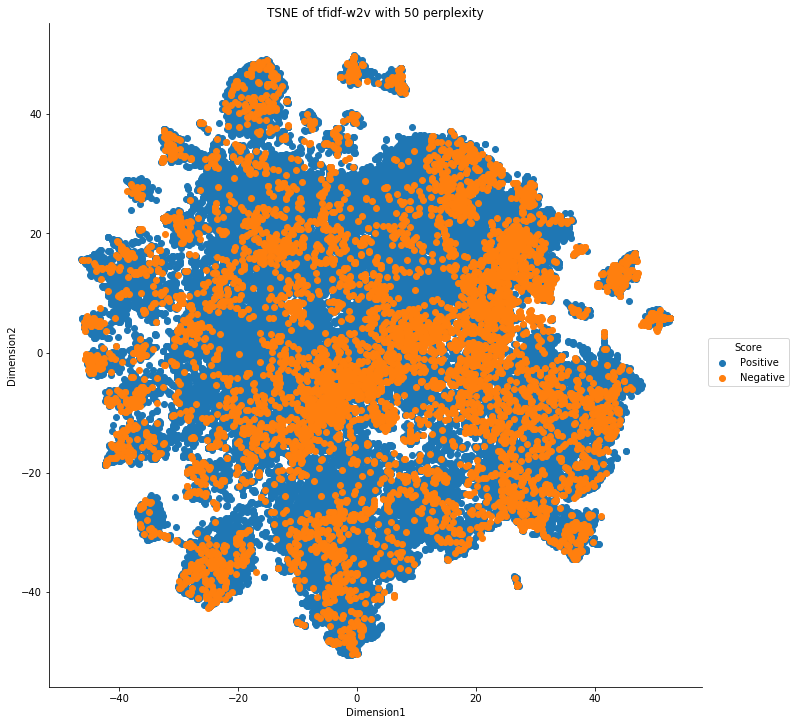

In [90]:
sns.FacetGrid(tfidf_w2v_dict['perplex_50_df'], hue='Score', size=10).\
map(plt.scatter, 'Dimension1','Dimension2').add_legend();
plt.title('TSNE of tfidf-w2v with 50 perplexity');

### observation : tsne of tfidf-w2v of positve and negative reviews with perplexity 30 and 50 are almost similar and and In both the tsne plots, Positve and Negative reviews are pretty much overlapped on each other.

## Conclusion:
1. Performed Data wrangling on amazon finefood reviews dataset from Kaggle
2. Assumed every review with less than 3 rating as negative review and greater than 3 as positive review and stored in a column called Score
3. Converted each review as vectors using techniques like Bag Of Words, Unigram Bigram, TFIDF, average word 2 vec, and TFIDF word 2 vec and done exploratory data analysis and plotted TSNE plots for every technique
4. Not even a single TSNE plot can distinguish the positive and negative reviews clearly. All the positive and negative reviews of every TSNE plots are pretty much overlapped on each other